In [ ]:
# Block 1: Installation
%pip install transformers==4.35.0
%pip install torch torchvision torchaudio
%pip install underthesea
%pip install onnx onnxruntime
%pip install optimum[onnxruntime]
%pip install datasets
%pip install accelerate -U
%pip install onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [ ]:
# ================================================================================
# CELL 1: IMPORTS VÀ SETUP
# ================================================================================

import re
import numpy as np
from typing import Dict, List, Optional
import torch
import unicodedata
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset
import json
import onnxruntime as ort

# Check dependencies
try:
    from underthesea import word_tokenize
    UNDERTHESEA_AVAILABLE = True
    print("✓ underthesea available")
except ImportError:
    UNDERTHESEA_AVAILABLE = False
    print("⚠️ underthesea not available - word segmentation disabled")

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Device: {device}")

✓ underthesea available
✓ Device: cuda


In [ ]:
# ================================================================================
# CELL 2: LOAD DATA
# ================================================================================

# Mount Google Drive (nếu dùng Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
# Thay đổi path theo file của bạn
data_path = '/content/drive/MyDrive/FakeNewsModels/MERGED_DATASET_FINAL.csv'
df = pd.read_csv(data_path)

# Kiểm tra data
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample data:")
print(df.head(2))

# Validate required columns
required_cols = ['title', 'content', 'label']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Clean data
df = df.dropna(subset=['title', 'content', 'label'])
df['label'] = df['label'].astype(int)
print(f"\n✓ Data cleaned. Final shape: {df.shape}")


Mounted at /content/drive
Dataset shape: (11859, 3)
Columns: ['title', 'content', 'label']

Label distribution:
label
0    8787
1    3072
Name: count, dtype: int64

Sample data:
  title                                            content  label
0   NaN  ĐẾN 18H CHIỀU 10/4 : THÊM 2 CA MẮC COVID-19 BN...      0
1   NaN  Thế giới tuần qua: Nợ công Mỹ tăng kinh hoàng ...      0

✓ Data cleaned. Final shape: (2459, 3)


In [ ]:
# ================================================================================
# CELL 3: TRAIN/VAL/TEST SPLIT (FIXED)
# ================================================================================

# Split data theo tỷ lệ: 70% train, 15% val, 15% test
print("Splitting dataset into train/val/test...")

# Bước 1: Split train vs (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,  # 30% cho val+test
    random_state=42,
    stratify=df['label']
)

# Bước 2: Split (val+test) thành val và test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # 50% của 30% = 15% cho test
    random_state=42,
    stratify=temp_df['label']
)

print(f"\n{'='*60}")
print(f"Dataset Split Summary")
print(f"{'='*60}")
print(f"Total samples:  {len(df):,}")
print(f"Train set:      {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val set:        {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set:       {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\n{'Label':<10} {'Train':<10} {'Val':<10} {'Test':<10}")
print(f"{'-'*40}")
for label in sorted(df['label'].unique()):
    train_count = (train_df['label'] == label).sum()
    val_count = (val_df['label'] == label).sum()
    test_count = (test_df['label'] == label).sum()
    print(f"{label:<10} {train_count:<10} {val_count:<10} {test_count:<10}")

# Reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\n✓ Data split completed")


Splitting dataset into train/val/test...

Dataset Split Summary
Total samples:  2,459
Train set:      1,721 (70.0%)
Val set:        369 (15.0%)
Test set:       369 (15.0%)

Label      Train      Val        Test      
----------------------------------------
0          748        160        161       
1          973        209        208       

✓ Data split completed


In [ ]:
# ================================================================================
# CELL 4: TEXT NORMALIZER
# ================================================================================

class VietnameseTextNormalizer:
    """Normalizer tối giản cho PhoBERT"""

    def __init__(self):
        self.use_word_segment = UNDERTHESEA_AVAILABLE

    def normalize_unicode(self, text: str) -> str:
        """Chuẩn hóa Unicode về NFC"""
        return unicodedata.normalize('NFC', text)

    def clean_special_chars(self, text: str) -> str:
        """Giữ chữ Việt + dấu câu cơ bản"""
        # Remove URLs
        text = re.sub(r'http[s]?://\S+', ' ', text)

        # Keep Vietnamese + punctuation
        text = re.sub(
            r'[^\w\s.,!?àáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđĐ]',
            ' ',
            text
        )

        return text

    def word_segment(self, text: str) -> str:
        """Tách từ cho PhoBERT"""
        if not self.use_word_segment:
            return text

        try:
            from underthesea import word_tokenize
            text = word_tokenize(text, format="text")
        except:
            pass

        return text

    def normalize(self, text: Optional[str], preserve_mask: bool = False) -> str:
        """Pipeline đơn giản"""
        if not text or not isinstance(text, str):
            return ""

        # 1. Unicode
        text = self.normalize_unicode(text)

        # 2. Clean
        text = text.strip()
        text = self.clean_special_chars(text)
        text = re.sub(r'\s+', ' ', text)

        # 3. Word segment
        if not preserve_mask:
            text = self.word_segment(text)

        # 4. Final cleanup
        text = re.sub(r'\s+', ' ', text).strip()

        return text

# Initialize normalizer
normalizer = VietnameseTextNormalizer()
print("✓ Text normalizer initialized")


✓ Text normalizer initialized


In [ ]:
# ================================================================================
# CELL 5: SEMANTIC CHUNKER (FIXED VERSION)
# ================================================================================

class SemanticChunkRetriever:
    """
    FIXED VERSION: Improved chunking với better handling of long sentences
    """
    def __init__(self, chunk_size=400):
        self.chunk_size = chunk_size

    def chunk_document(self, text):
        """
        FIX: Thêm dấu '-' vào pattern và handle oversized chunks
        """
        # Split by sentence-ending punctuation AND dash
        sentences = re.split(r'[.!?\-]\s+', text)  # ← FIXED: Added '-'
        chunks = []
        current_chunk = []
        current_len = 0

        for sent in sentences:
            if not sent.strip():
                continue

            # FIX: Hard limit để tránh oversized chunks
            if current_len + len(sent) > self.chunk_size:
                if current_chunk:  # Save current chunk
                    chunks.append(' . '.join(current_chunk))

                # FIX: Nếu sentence đơn lẻ quá dài, split by words
                if len(sent) > self.chunk_size * 1.5:
                    words = sent.split()
                    temp_chunk = []
                    temp_len = 0
                    for word in words:
                        if temp_len + len(word) > self.chunk_size:
                            if temp_chunk:
                                chunks.append(' '.join(temp_chunk))
                            temp_chunk = [word]
                            temp_len = len(word)
                        else:
                            temp_chunk.append(word)
                            temp_len += len(word) + 1
                    if temp_chunk:
                        current_chunk = temp_chunk
                        current_len = temp_len
                else:
                    current_chunk = [sent]
                    current_len = len(sent)
            else:
                current_chunk.append(sent)
                current_len += len(sent)

        if current_chunk:
            chunks.append(' . '.join(current_chunk))

        return chunks

# Initialize chunker
chunker = SemanticChunkRetriever(chunk_size=400)
print("✓ Semantic chunker initialized (FIXED)")


✓ Semantic chunker initialized (FIXED)


In [ ]:
# ================================================================================
# CELL 6: LOAD MODELS (TOKENIZER & RETRIEVER)
# ================================================================================

print("Loading PhoBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base-v2')
print("✓ PhoBERT tokenizer loaded")

print("\nLoading Vietnamese-SBERT for RAG retrieval...")
retriever = SentenceTransformer('keepitreal/vietnamese-sbert')
retriever.eval()
print("✓ Vietnamese-SBERT loaded")


Loading PhoBERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✓ PhoBERT tokenizer loaded

Loading Vietnamese-SBERT for RAG retrieval...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Vietnamese-SBERT loaded


In [ ]:
# ================================================================================
# CELL 7: CHUNK ATTENTION LAYER
# ================================================================================

class ChunkAttentionLayer(nn.Module):
    """
    Attention mechanism ở chunk level
    Input: [batch, num_chunks, hidden_size]
    Output:
        - context: [batch, hidden_size] - weighted sum của chunks
        - attention_weights: [batch, num_chunks] - attention scores
    """
    def __init__(self, hidden_size: int, attention_hidden: int = 128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, attention_hidden),
            nn.Tanh(),
            nn.Linear(attention_hidden, 1)
        )

    def forward(self, chunk_embeddings: torch.Tensor, mask: torch.Tensor = None):
        """
        Args:
            chunk_embeddings: [batch, num_chunks, hidden_size]
            mask: [batch, num_chunks] - 1 for valid chunks, 0 for padding

        Returns:
            context: [batch, hidden_size]
            attention_weights: [batch, num_chunks]
        """
        # Calculate attention scores: [batch, num_chunks, 1]
        scores = self.attention(chunk_embeddings)
        scores = scores.squeeze(-1)  # [batch, num_chunks]

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=1)  # [batch, num_chunks]

        # Weighted sum: [batch, hidden_size]
        context = torch.bmm(
            attention_weights.unsqueeze(1),  # [batch, 1, num_chunks]
            chunk_embeddings                  # [batch, num_chunks, hidden_size]
        ).squeeze(1)  # [batch, hidden_size]

        return context, attention_weights

print("✓ ChunkAttentionLayer defined")


✓ ChunkAttentionLayer defined


In [ ]:
# ================================================================================
# CELL 8: DATASET (FIXED VERSION)
# ================================================================================

class HierarchicalAttentionDataset(Dataset):
    """
    FIXED VERSION: No empty padding, better RAG retrieval

    KEY FIXES:
    1. No empty string padding - duplicate chunks instead
    2. Minimum chunks validation
    3. Similarity threshold for RAG
    4. Chunk length validation before tokenization
    """
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        normalizer: VietnameseTextNormalizer,
        retriever: SentenceTransformer,
        chunk_size: int = 400,
        top_k: int = 5,
        max_length: int = 256,
        min_chunks: int = 3,  # NEW: Minimum chunks required
        min_similarity: float = 0.15,  # NEW: Minimum similarity threshold
        verbose: bool = False
    ):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.normalizer = normalizer
        self.retriever = retriever
        self.chunk_size = chunk_size
        self.top_k = top_k
        self.max_length = max_length
        self.min_chunks = min_chunks
        self.min_similarity = min_similarity
        self.verbose = verbose

        # Helper chunker
        self.chunker = SemanticChunkRetriever(chunk_size=chunk_size)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        label = int(row['label'])

        # 1. Lấy Title và Content
        title = str(row.get('title', ''))
        content = str(row.get('content', ''))

        # Normalize
        title = self.normalizer.normalize(title)
        content = self.normalizer.normalize(content)

        # 2. Chunking Content
        raw_chunks = self.chunker.chunk_document(content)

        # ========================================
        # FIX 1: VALIDATE MINIMUM CHUNKS
        # ========================================
        if len(raw_chunks) < self.min_chunks:
            if self.verbose:
                print(f"⚠️ Sample {idx} only has {len(raw_chunks)} chunks < min {self.min_chunks}")
            # Duplicate chunks to reach minimum
            while len(raw_chunks) < self.min_chunks:
                raw_chunks.extend(raw_chunks[:self.min_chunks - len(raw_chunks)])

        # 3. RAG LOGIC: Retrieve Top-K chunks
        if len(raw_chunks) <= self.top_k:
            selected_chunks = raw_chunks
        else:
            # Use title as query, fallback to first chunk
            query = title if title.strip() else raw_chunks[0]

            # Encode query and chunks
            query_emb = self.retriever.encode(query, convert_to_tensor=True)
            chunk_embs = self.retriever.encode(raw_chunks, convert_to_tensor=True)

            # Compute similarities
            similarities = F.cosine_similarity(
                query_emb.unsqueeze(0),
                chunk_embs,
                dim=1
            )

            # ========================================
            # FIX 2: FILTER LOW-SIMILARITY CHUNKS
            # ========================================
            valid_indices = (similarities >= self.min_similarity).nonzero(as_tuple=True)[0]

            if len(valid_indices) < self.top_k:
                # Not enough valid chunks, take top-k anyway
                top_indices = similarities.argsort(descending=True)[:self.top_k]
            else:
                # Sort valid indices by similarity and take top-k
                valid_sims = similarities[valid_indices]
                sorted_valid = valid_indices[valid_sims.argsort(descending=True)]
                top_indices = sorted_valid[:self.top_k]

            selected_chunks = [raw_chunks[i] for i in top_indices]

        # ========================================
        # FIX 3: NO EMPTY PADDING - DUPLICATE INSTEAD
        # ========================================
        while len(selected_chunks) < self.top_k:
            # Duplicate existing chunks cyclically
            selected_chunks.append(
                selected_chunks[len(selected_chunks) % len(raw_chunks)]
            )

        # Truncate if over
        selected_chunks = selected_chunks[:self.top_k]

        # ========================================
        # FIX 4: VALIDATE CHUNK LENGTHS
        # ========================================
        max_chars = self.max_length * 4  # Conservative: 4 chars per token
        validated_chunks = []
        for chunk in selected_chunks:
            if len(chunk) > max_chars:
                if self.verbose:
                    print(f"⚠️ Chunk too long ({len(chunk)} chars), truncating to {max_chars}")
                chunk = chunk[:max_chars]
            validated_chunks.append(chunk)

        # 4. Tokenize chunks
        chunk_encodings = self.tokenizer(
            validated_chunks,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'chunk_input_ids': chunk_encodings['input_ids'],
            'chunk_attention_masks': chunk_encodings['attention_mask'],
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✓ HierarchicalAttentionDataset defined (FIXED)")


✓ HierarchicalAttentionDataset defined (FIXED)


In [ ]:
# ================================================================================
# CELL 9: HAN MODEL
# ================================================================================

class HierarchicalAttentionClassifier(nn.Module):
    """
    Hierarchical Attention Network cho phân loại fake news

    Architecture:
    1. PhoBERT encode từng chunk → chunk embeddings
    2. Chunk-level attention → document representation
    3. Classification head → logits
    """
    def __init__(
        self,
        phobert_name: str = "vinai/phobert-base-v2",
        chunk_attention_hidden: int = 128,
        num_classes: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()

        # PhoBERT encoder
        self.phobert = AutoModel.from_pretrained(phobert_name)
        self.hidden_size = self.phobert.config.hidden_size  # 768

        # Chunk-level attention
        self.chunk_attention = ChunkAttentionLayer(
            hidden_size=self.hidden_size,
            attention_hidden=chunk_attention_hidden
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size // 2, num_classes)
        )

    def encode_chunks(
        self,
        chunk_input_ids: torch.Tensor,
        chunk_attention_masks: torch.Tensor
    ) -> torch.Tensor:
        """
        Encode từng chunk bằng PhoBERT

        Args:
            chunk_input_ids: [batch, num_chunks, max_length]
            chunk_attention_masks: [batch, num_chunks, max_length]

        Returns:
            chunk_embeddings: [batch, num_chunks, hidden_size]
        """
        batch_size, num_chunks, max_length = chunk_input_ids.shape

        # Reshape to [batch * num_chunks, max_length]
        flat_input_ids = chunk_input_ids.view(-1, max_length)
        flat_attention_masks = chunk_attention_masks.view(-1, max_length)

        # Encode with PhoBERT
        outputs = self.phobert(
            input_ids=flat_input_ids,
            attention_mask=flat_attention_masks
        )

        # Get [CLS] token embeddings: [batch * num_chunks, hidden_size]
        chunk_embeddings = outputs.last_hidden_state[:, 0, :]

        # Reshape back: [batch, num_chunks, hidden_size]
        chunk_embeddings = chunk_embeddings.view(batch_size, num_chunks, -1)

        return chunk_embeddings

    def forward(
        self,
        chunk_input_ids: torch.Tensor,
        chunk_attention_masks: torch.Tensor
    ):
        """
        Forward pass

        Args:
            chunk_input_ids: [batch, num_chunks, max_length]
            chunk_attention_masks: [batch, num_chunks, max_length]

        Returns:
            dict with:
                - logits: [batch, num_classes]
                - chunk_attention: [batch, num_chunks]
        """
        # 1. Encode chunks: [batch, num_chunks, hidden_size]
        chunk_embeddings = self.encode_chunks(chunk_input_ids, chunk_attention_masks)

        # 2. Create chunk-level mask
        chunk_mask = (chunk_attention_masks.sum(dim=2) > 0).float()

        # 3. Apply chunk-level attention
        doc_representation, chunk_attention_weights = self.chunk_attention(
            chunk_embeddings,
            mask=chunk_mask
        )

        # 4. Classification
        logits = self.classifier(doc_representation)

        return {
            'logits': logits,
            'chunk_attention': chunk_attention_weights
        }

print("✓ HierarchicalAttentionClassifier defined")


✓ HierarchicalAttentionClassifier defined


In [ ]:
# ================================================================================
# CELL 10: CREATE DATASETS (UPDATED - THÊM TEST SET)
# ================================================================================

print("Creating training dataset...")
train_dataset = HierarchicalAttentionDataset(
    df=train_df,
    tokenizer=tokenizer,
    normalizer=normalizer,
    retriever=retriever,
    chunk_size=400,
    top_k=5,
    max_length=256,
    min_chunks=3,
    min_similarity=0.15,
    verbose=False
)
print(f"✓ Train dataset: {len(train_dataset)} samples")

print("\nCreating validation dataset...")
val_dataset = HierarchicalAttentionDataset(
    df=val_df,
    tokenizer=tokenizer,
    normalizer=normalizer,
    retriever=retriever,
    chunk_size=400,
    top_k=5,
    max_length=256,
    min_chunks=3,
    min_similarity=0.15,
    verbose=False
)
print(f"✓ Val dataset: {len(val_dataset)} samples")

print("\nCreating test dataset...")
test_dataset = HierarchicalAttentionDataset(
    df=test_df,
    tokenizer=tokenizer,
    normalizer=normalizer,
    retriever=retriever,
    chunk_size=400,
    top_k=5,
    max_length=256,
    min_chunks=3,
    min_similarity=0.15,
    verbose=False
)
print(f"✓ Test dataset: {len(test_dataset)} samples")

# Test one sample
print("\n### Testing Dataset ###")
sample = train_dataset[0]
print(f"Sample shape:")
print(f"  chunk_input_ids: {sample['chunk_input_ids'].shape}")
print(f"  chunk_attention_masks: {sample['chunk_attention_masks'].shape}")
print(f"  label: {sample['label']}")

# Check for empty chunks
for i in range(5):
    num_tokens = (sample['chunk_input_ids'][i] != tokenizer.pad_token_id).sum().item()
    print(f"  Chunk {i}: {num_tokens} tokens")

min_tokens = min(
    (sample['chunk_input_ids'][i] != tokenizer.pad_token_id).sum().item()
    for i in range(5)
)
print(f"\n{'✅ GOOD' if min_tokens > 10 else '❌ ISSUE'}: Min tokens = {min_tokens}")


Creating training dataset...
✓ Train dataset: 1721 samples

Creating validation dataset...
✓ Val dataset: 369 samples

Creating test dataset...
✓ Test dataset: 369 samples

### Testing Dataset ###
Sample shape:
  chunk_input_ids: torch.Size([5, 256])
  chunk_attention_masks: torch.Size([5, 256])
  label: 1
  Chunk 0: 70 tokens
  Chunk 1: 74 tokens
  Chunk 2: 70 tokens
  Chunk 3: 70 tokens
  Chunk 4: 70 tokens

✅ GOOD: Min tokens = 70


In [ ]:
# ================================================================================
# CELL 11: TRAINING SETUP (FIXED - NO MULTIPROCESSING WITH CUDA)
# ================================================================================

# Initialize model
model = HierarchicalAttentionClassifier(
    phobert_name='vinai/phobert-base-v2',
    chunk_attention_hidden=128,
    num_classes=2,
    dropout=0.3
).to(device)

print(f"✓ Model initialized on {device}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ========================================
# FIX: SET num_workers=0 WHEN USING CUDA
# ========================================
use_cuda = torch.cuda.is_available()
num_workers = 0  # MUST be 0 with CUDA + sentence_transformers

if use_cuda:
    print("\n⚠️ CUDA detected: Setting num_workers=0 to avoid multiprocessing errors")
else:
    num_workers = 2

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,  # ← FIXED
    pin_memory=False  # ← FIXED: Also set to False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,  # ← FIXED
    pin_memory=False  # ← FIXED
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,  # ← FIXED
    pin_memory=False  # ← FIXED
)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  num_workers: {num_workers} (CUDA multiprocessing disabled)")

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
)

print(f"\n✓ Training components ready")
print(f"  Optimizer: AdamW (lr=2e-5)")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau (patience=2)")

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model initialized on cuda
  Total parameters: 135,392,899
  Trainable parameters: 135,392,899

⚠️ CUDA detected: Setting num_workers=0 to avoid multiprocessing errors

✓ DataLoaders created
  Train batches: 108
  Val batches: 24
  Test batches: 24
  num_workers: 0 (CUDA multiprocessing disabled)

✓ Training components ready
  Optimizer: AdamW (lr=2e-5)
  Loss: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau (patience=2)


In [ ]:
# ================================================================================
# CELL 12: TRAINING LOOP WITH EARLY STOPPING (SAVE TO DRIVE)
# ================================================================================

# ========================================
# SETUP SAVE PATHS TO GOOGLE DRIVE
# ========================================

# Tạo thư mục trong Drive nếu chưa có
drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
os.makedirs(drive_save_dir, exist_ok=True)

# Define save paths
best_model_path = os.path.join(drive_save_dir, 'han_rag_best.pth')
last_model_path = os.path.join(drive_save_dir, 'han_rag_last.pth')
history_path = os.path.join(drive_save_dir, 'training_history.json')

print(f"✓ Models will be saved to: {drive_save_dir}")
print(f"  - Best model: {best_model_path}")
print(f"  - Last model: {last_model_path}")
print(f"  - History: {history_path}")

# Early stopping parameters
best_val_f1 = 0
patience = 3
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': []
}

num_epochs = 10

print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

for epoch in range(num_epochs):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch+1}/{num_epochs}")
    print(f"{'='*80}")

    # ========================================
    # TRAINING PHASE
    # ========================================
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch_idx, batch in enumerate(pbar):
        chunk_input_ids = batch['chunk_input_ids'].to(device)
        chunk_attention_masks = batch['chunk_attention_masks'].to(device)
        labels = batch['label'].to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(chunk_input_ids, chunk_attention_masks)
        logits = outputs['logits']

        # Loss
        loss = criterion(logits, labels)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })

        # Log attention warnings
        if batch_idx % 100 == 0 and batch_idx > 0:
            chunk_attention = outputs['chunk_attention']
            avg_pad_ratio = (chunk_attention_masks == 0).float().mean().item()
            if avg_pad_ratio > 0.7:
                print(f"\n⚠️ High padding ratio: {avg_pad_ratio:.2%}")

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # ========================================
    # VALIDATION PHASE
    # ========================================
    model.eval()
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            chunk_input_ids = batch['chunk_input_ids'].to(device)
            chunk_attention_masks = batch['chunk_attention_masks'].to(device)
            labels = batch['label'].to(device)

            outputs = model(chunk_input_ids, chunk_attention_masks)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    # Calculate metrics
    val_acc = accuracy_score(val_labels_list, val_preds)
    val_f1 = f1_score(val_labels_list, val_preds, average='macro')
    val_precision = precision_score(val_labels_list, val_preds, average='macro')
    val_recall = recall_score(val_labels_list, val_preds, average='macro')

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)

    # Print results
    print(f"\n### EPOCH {epoch+1} RESULTS ###")
    print(f"Train Loss:     {train_loss:.4f}")
    print(f"Train Acc:      {train_acc:.4f}")
    print(f"Val Acc:        {val_acc:.4f}")
    print(f"Val F1:         {val_f1:.4f}")
    print(f"Val Precision:  {val_precision:.4f}")
    print(f"Val Recall:     {val_recall:.4f}")

    # Scheduler step
    scheduler.step(val_f1)

    # ========================================
    # SAVE CHECKPOINT TO GOOGLE DRIVE
    # ========================================
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_f1': val_f1,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'history': history,
        'best_val_f1': best_val_f1
    }

    # Save last checkpoint (overwrite every epoch)
    torch.save(checkpoint, last_model_path)

    # Early stopping logic
    if val_f1 > best_val_f1:
        improvement = val_f1 - best_val_f1
        best_val_f1 = val_f1
        patience_counter = 0

        # Save best model to Drive
        torch.save(checkpoint, best_model_path)
        print(f"✅ New best model saved! Val F1: {best_val_f1:.4f} (↑{improvement:.4f})")
        print(f"   Saved to: {best_model_path}")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered!")
            print(f"   Best Val F1: {best_val_f1:.4f} (Epoch {checkpoint['epoch'] - patience_counter})")
            break

    # Save training history to JSON after each epoch
    import json
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)

print("\n" + "="*80)
print("✅ TRAINING COMPLETED")
print("="*80)
print(f"Best Val F1: {best_val_f1:.4f}")
print(f"\nSaved files in Google Drive:")
print(f"  📁 {drive_save_dir}")
print(f"    ├── han_rag_best.pth (best model)")
print(f"    ├── han_rag_last.pth (last epoch)")
print(f"    └── training_history.json")

✓ Models will be saved to: /content/drive/MyDrive/FakeNewsModels/model_v2
  - Best model: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth
  - Last model: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_last.pth
  - History: /content/drive/MyDrive/FakeNewsModels/model_v2/training_history.json

STARTING TRAINING

EPOCH 1/10


Training Epoch 1:   0%|          | 0/108 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]


⚠️ High padding ratio: 72.27%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 1 RESULTS ###
Train Loss:     0.4259
Train Acc:      0.8373
Val Acc:        0.8997
Val F1:         0.8966
Val Precision:  0.9040
Val Recall:     0.8924
✅ New best model saved! Val F1: 0.8966 (↑0.8966)
   Saved to: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth

EPOCH 2/10


Training Epoch 2:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 73.94%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 2 RESULTS ###
Train Loss:     0.2596
Train Acc:      0.9128
Val Acc:        0.9214
Val F1:         0.9190
Val Precision:  0.9268
Val Recall:     0.9145
✅ New best model saved! Val F1: 0.9190 (↑0.0224)
   Saved to: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth

EPOCH 3/10


Training Epoch 3:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 72.80%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 3 RESULTS ###
Train Loss:     0.1681
Train Acc:      0.9529
Val Acc:        0.9458
Val F1:         0.9451
Val Precision:  0.9436
Val Recall:     0.9470
✅ New best model saved! Val F1: 0.9451 (↑0.0261)
   Saved to: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth

EPOCH 4/10


Training Epoch 4:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 72.14%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 4 RESULTS ###
Train Loss:     0.0964
Train Acc:      0.9750
Val Acc:        0.9187
Val F1:         0.9156
Val Precision:  0.9292
Val Recall:     0.9092
⚠️ No improvement. Patience: 1/3

EPOCH 5/10


Training Epoch 5:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 73.25%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 5 RESULTS ###
Train Loss:     0.0696
Train Acc:      0.9797
Val Acc:        0.9621
Val F1:         0.9614
Val Precision:  0.9614
Val Recall:     0.9614
✅ New best model saved! Val F1: 0.9614 (↑0.0163)
   Saved to: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth

EPOCH 6/10


Training Epoch 6:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 74.63%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 6 RESULTS ###
Train Loss:     0.0537
Train Acc:      0.9849
Val Acc:        0.9593
Val F1:         0.9586
Val Precision:  0.9589
Val Recall:     0.9583
⚠️ No improvement. Patience: 1/3

EPOCH 7/10


Training Epoch 7:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 71.36%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 7 RESULTS ###
Train Loss:     0.0272
Train Acc:      0.9948
Val Acc:        0.9485
Val F1:         0.9480
Val Precision:  0.9460
Val Recall:     0.9516
⚠️ No improvement. Patience: 2/3

EPOCH 8/10


Training Epoch 8:   0%|          | 0/108 [00:00<?, ?it/s]


⚠️ High padding ratio: 73.30%


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


### EPOCH 8 RESULTS ###
Train Loss:     0.0144
Train Acc:      0.9983
Val Acc:        0.9458
Val F1:         0.9451
Val Precision:  0.9434
Val Recall:     0.9478
⚠️ No improvement. Patience: 3/3

🛑 Early stopping triggered!
   Best Val F1: 0.9614 (Epoch 5)

✅ TRAINING COMPLETED
Best Val F1: 0.9614

Saved files in Google Drive:
  📁 /content/drive/MyDrive/FakeNewsModels/model_v2
    ├── han_rag_best.pth (best model)
    ├── han_rag_last.pth (last epoch)
    └── training_history.json


Loading training history from: /content/drive/MyDrive/FakeNewsModels/model_v2/training_history.json
✓ Loaded history with 7 epochs
✓ Plot saved to: /content/drive/MyDrive/FakeNewsModels/model_v2/training_history.png


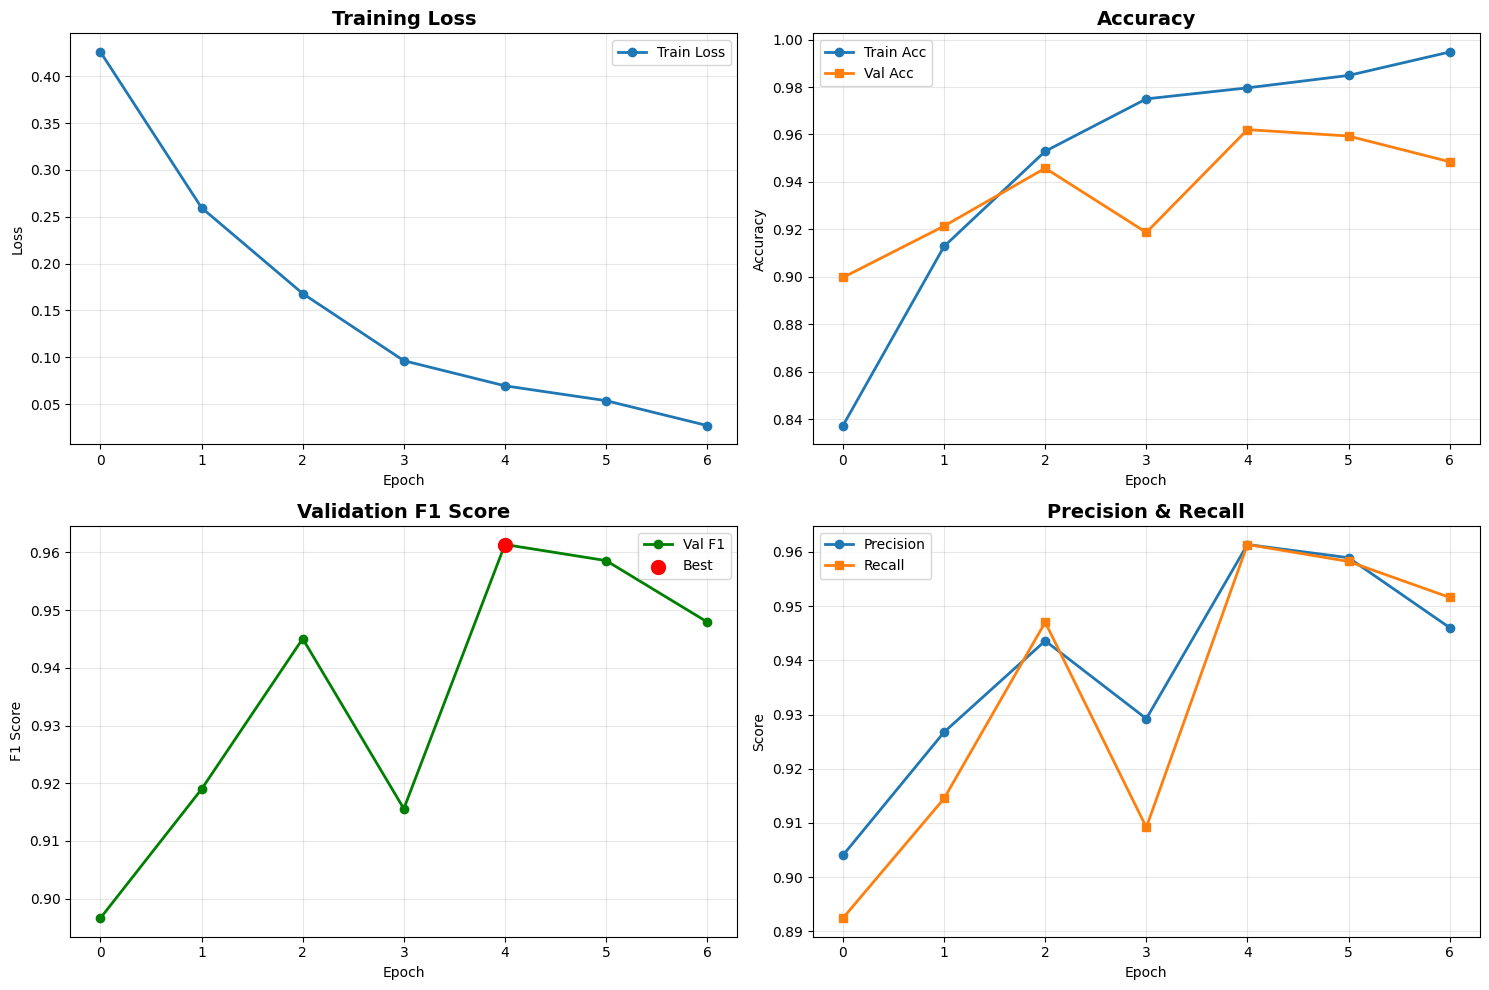


TRAINING SUMMARY
Total epochs: 7
Best epoch: 5
Best Val F1: 0.9614
Final Train Loss: 0.0272
Final Train Acc: 0.9948
Final Val F1: 0.9480


In [ ]:
# ================================================================================
# CELL 13: PLOT TRAINING HISTORY (LOAD FROM DRIVE)
# ================================================================================

# Load history from Drive
drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
history_path = os.path.join(drive_save_dir, 'training_history.json')

print(f"Loading training history from: {history_path}")
with open(history_path, 'r') as f:
    history = json.load(f)

print(f"✓ Loaded history with {len(history['train_loss'])} epochs")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1 Score
axes[1, 0].plot(history['val_f1'], label='Val F1', marker='o', color='green', linewidth=2)
axes[1, 0].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Highlight best epoch
best_epoch = history['val_f1'].index(max(history['val_f1']))
axes[1, 0].scatter(best_epoch, max(history['val_f1']),
                   color='red', s=100, zorder=5, label='Best')
axes[1, 0].legend()

# Plot 4: Precision & Recall
axes[1, 1].plot(history['val_precision'], label='Precision', marker='o', linewidth=2)
axes[1, 1].plot(history['val_recall'], label='Recall', marker='s', linewidth=2)
axes[1, 1].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save to Drive
plot_path = os.path.join(drive_save_dir, 'training_history.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Plot saved to: {plot_path}")
plt.show()

# Print summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Best epoch: {best_epoch + 1}")
print(f"Best Val F1: {max(history['val_f1']):.4f}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Train Acc: {history['train_acc'][-1]:.4f}")
print(f"Final Val F1: {history['val_f1'][-1]:.4f}")

In [ ]:
# ================================================================================
# CELL 14: VALIDATION SET SUMMARY (LOAD FROM DRIVE)
# ================================================================================

# Load best model from Drive
drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
best_model_path = os.path.join(drive_save_dir, 'han_rag_best.pth')

print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']} (Val F1={checkpoint['val_f1']:.4f})")

# Quick validation metrics
model.eval()
val_preds = []
val_labels_list = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation"):
        chunk_input_ids = batch['chunk_input_ids'].to(device)
        chunk_attention_masks = batch['chunk_attention_masks'].to(device)
        labels = batch['label'].to(device)

        outputs = model(chunk_input_ids, chunk_attention_masks)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels_list.extend(labels.cpu().numpy())

# Calculate metrics
val_acc = accuracy_score(val_labels_list, val_preds)
val_f1 = f1_score(val_labels_list, val_preds, average='macro')
val_precision = precision_score(val_labels_list, val_preds, average='macro')
val_recall = recall_score(val_labels_list, val_preds, average='macro')

print("\n" + "="*80)
print("VALIDATION SET METRICS (BEST MODEL)")
print("="*80)
print(f"Accuracy:   {val_acc:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")

# Simple confusion matrix
cm = confusion_matrix(val_labels_list, val_preds)
print(f"\nConfusion Matrix:")
print(f"  [[{cm[0,0]:4d}, {cm[0,1]:4d}]   (REAL)")
print(f"   [{cm[1,0]:4d}, {cm[1,1]:4d}]]  (FAKE)")
print(f"     REAL  FAKE")

print("\n✓ Validation complete. Proceed to final test evaluation.")

Loading best model from: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth
✓ Loaded best model from epoch 5 (Val F1=0.9614)


Validation:   0%|          | 0/24 [00:00<?, ?it/s]


VALIDATION SET METRICS (BEST MODEL)
Accuracy:   0.9621
F1 Score:   0.9614
Precision:  0.9614
Recall:     0.9614

Confusion Matrix:
  [[ 153,    7]   (REAL)
   [   7,  202]]  (FAKE)
     REAL  FAKE

✓ Validation complete. Proceed to final test evaluation.


In [ ]:
# ================================================================================
# CELL 15: TEST WITH EXAMPLE
# ================================================================================

def predict_news(title, content, model, tokenizer, normalizer, retriever, device):
    """Test model với 1 sample"""
    # Create mini dataset
    test_df = pd.DataFrame({
        'title': [title],
        'content': [content],
        'label': [0]  # Dummy label
    })

    test_dataset = HierarchicalAttentionDataset(
        df=test_df,
        tokenizer=tokenizer,
        normalizer=normalizer,
        retriever=retriever,
        chunk_size=400,
        top_k=5,
        max_length=256,
        min_chunks=3
    )

    sample = test_dataset[0]
    chunk_input_ids = sample['chunk_input_ids'].unsqueeze(0).to(device)
    chunk_attention_masks = sample['chunk_attention_masks'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(chunk_input_ids, chunk_attention_masks)
        logits = outputs['logits']
        chunk_attention = outputs['chunk_attention']
        probs = F.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    print(f"\n{'='*80}")
    print("PREDICTION RESULT")
    print(f"{'='*80}")
    print(f"\nTitle: {title}")
    print(f"Content (first 200 chars): {content[:200]}...")
    print(f"\nPrediction: {'FAKE' if pred_class == 1 else 'REAL'}")
    print(f"Confidence: {probs[0, pred_class].item():.4f}")
    print(f"Probabilities: REAL={probs[0,0]:.4f}, FAKE={probs[0,1]:.4f}")

    print(f"\n### Chunk Attention Weights ###")
    for i in range(5):
        num_tokens = (chunk_input_ids[0, i] != tokenizer.pad_token_id).sum().item()
        attention = chunk_attention[0, i].item()
        print(f"Chunk {i}: {attention:.4f} ({num_tokens} tokens)")

# Test with COVID-19 example
test_title = "NÓNG: Thế giới đối mặt với COVID-19"
test_content = """NÓNG ! 15/3 sẽ là ngày đáng nhớ cho không chỉ Việt Nam mà của toàn thế giới do những gì COVID-19 gây ra !!! - Rạng sáng 15/3, Pháp ra lệnh đóng cửa toàn bộ nhà hàng, rạp chiếu phim, cửa hàng,..trừ.. siêu thị, trạm xăng, ngân hàng, tabac, presse báo chí và pharmacie. Phong tỏa 1 phần đất nước. - Chủ tịch hiệp hội Y Tế Ý vừa qua đời vì Corona Virus. Hưởng thọ 67 tuổi.. - Vợ thủ tướng Canada đã dương tính Corona Virus . Ông cũng đang bị cách ly"""

predict_news(test_title, test_content, model, tokenizer, normalizer, retriever, device)

print("\n" + "="*80)
print("✅ ALL TESTS COMPLETED")
print("="*80)



PREDICTION RESULT

Title: NÓNG: Thế giới đối mặt với COVID-19
Content (first 200 chars): NÓNG ! 15/3 sẽ là ngày đáng nhớ cho không chỉ Việt Nam mà của toàn thế giới do những gì COVID-19 gây ra !!! - Rạng sáng 15/3, Pháp ra lệnh đóng cửa toàn bộ nhà hàng, rạp chiếu phim, cửa hàng,..trừ.. s...

Prediction: REAL
Confidence: 0.9812
Probabilities: REAL=0.9812, FAKE=0.0188

### Chunk Attention Weights ###
Chunk 0: 0.2254 (92 tokens)
Chunk 1: 0.0984 (16 tokens)
Chunk 2: 0.2254 (92 tokens)
Chunk 3: 0.2254 (92 tokens)
Chunk 4: 0.2254 (92 tokens)

✅ ALL TESTS COMPLETED


In [ ]:
# ================================================================================
# CELL 16: FINAL EVALUATION ON TEST SET (NEW)
# ================================================================================

print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

# Load best model
drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
best_model_path = os.path.join(drive_save_dir, 'han_rag_best.pth')

print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']} (Val F1={checkpoint['val_f1']:.4f})")

# Evaluate on test set
model.eval()
test_preds = []
test_labels_list = []
test_probs = []
test_attention_weights = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        chunk_input_ids = batch['chunk_input_ids'].to(device)
        chunk_attention_masks = batch['chunk_attention_masks'].to(device)
        labels = batch['label'].to(device)

        outputs = model(chunk_input_ids, chunk_attention_masks)
        logits = outputs['logits']
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_attention_weights.extend(outputs['chunk_attention'].cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(test_labels_list, test_preds)
test_f1 = f1_score(test_labels_list, test_preds, average='macro')
test_f1_weighted = f1_score(test_labels_list, test_preds, average='weighted')
test_precision = precision_score(test_labels_list, test_preds, average='macro')
test_recall = recall_score(test_labels_list, test_preds, average='macro')

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Accuracy:          {test_acc:.4f}")
print(f"F1 Score (Macro):  {test_f1:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")
print(f"Precision:         {test_precision:.4f}")
print(f"Recall:            {test_recall:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print(classification_report(
    test_labels_list,
    test_preds,
    target_names=['REAL', 'FAKE'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels_list, test_preds)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives (REAL predicted as REAL):  {cm[0,0]}")
print(f"False Positives (REAL predicted as FAKE): {cm[0,1]}")
print(f"False Negatives (FAKE predicted as REAL): {cm[1,0]}")
print(f"True Positives (FAKE predicted as FAKE):  {cm[1,1]}")

# Analyze attention patterns
test_attention_weights = np.array(test_attention_weights)
mean_attention = test_attention_weights.mean(axis=0)
print(f"\n{'='*80}")
print("ATTENTION ANALYSIS (TEST SET)")
print(f"{'='*80}")
print(f"\nAverage attention weights across all test samples:")
for i, weight in enumerate(mean_attention):
    bar_length = int(weight * 40 / mean_attention.max())
    bar = "█" * bar_length
    print(f"Chunk {i}: {bar} {weight:.4f}")

# Compare train/val/test performance
print(f"\n{'='*80}")
print("PERFORMANCE COMPARISON")
print(f"{'='*80}")
print(f"{'Split':<15} {'Accuracy':<12} {'F1 (Macro)':<12}")
print(f"{'-'*40}")
print(f"{'Validation':<15} {val_acc:.4f}       {checkpoint['val_f1']:.4f}")
print(f"{'Test':<15} {test_acc:.4f}       {test_f1:.4f}")

gap = abs(checkpoint['val_f1'] - test_f1)
if gap < 0.02:
    print(f"\n✅ GOOD: Val-Test gap = {gap:.4f} (< 0.02) → Model generalizes well")
elif gap < 0.05:
    print(f"\n⚠️ ACCEPTABLE: Val-Test gap = {gap:.4f} (< 0.05) → Minor overfitting")
else:
    print(f"\n❌ WARNING: Val-Test gap = {gap:.4f} (> 0.05) → Significant overfitting!")

# Save test results
test_results = {
    'test_accuracy': test_acc,
    'test_f1_macro': test_f1,
    'test_f1_weighted': test_f1_weighted,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'confusion_matrix': cm.tolist(),
    'mean_attention_weights': mean_attention.tolist()
}

# Save test results to Drive
test_results_path = os.path.join(drive_save_dir, 'test_results.json')
with open(test_results_path, 'w', encoding='utf-8') as f:
    json.dump(test_results, f, indent=2, ensure_ascii=False)

print(f"\n✓ Detailed test results saved to: {test_results_path}")


FINAL EVALUATION ON TEST SET
Loading best model from: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_best.pth
✓ Loaded best model from epoch 5 (Val F1=0.9614)


Testing:   0%|          | 0/24 [00:00<?, ?it/s]


TEST SET RESULTS
Accuracy:          0.9539
F1 Score (Macro):  0.9531
F1 Score (Weighted): 0.9539
Precision:         0.9535
Recall:            0.9528

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

        REAL     0.9500    0.9441    0.9470       161
        FAKE     0.9569    0.9615    0.9592       208

    accuracy                         0.9539       369
   macro avg     0.9535    0.9528    0.9531       369
weighted avg     0.9539    0.9539    0.9539       369


Confusion Matrix:
[[152   9]
 [  8 200]]

True Negatives (REAL predicted as REAL):  152
False Positives (REAL predicted as FAKE): 9
False Negatives (FAKE predicted as REAL): 8
True Positives (FAKE predicted as FAKE):  200

ATTENTION ANALYSIS (TEST SET)

Average attention weights across all test samples:
Chunk 0: ████████████████████████████████████████ 0.2035
Chunk 1: ███████████████████████████████████████ 0.2025
Chunk 2: ██████████████████████████████████████ 0.1975
Chunk 3: ██████

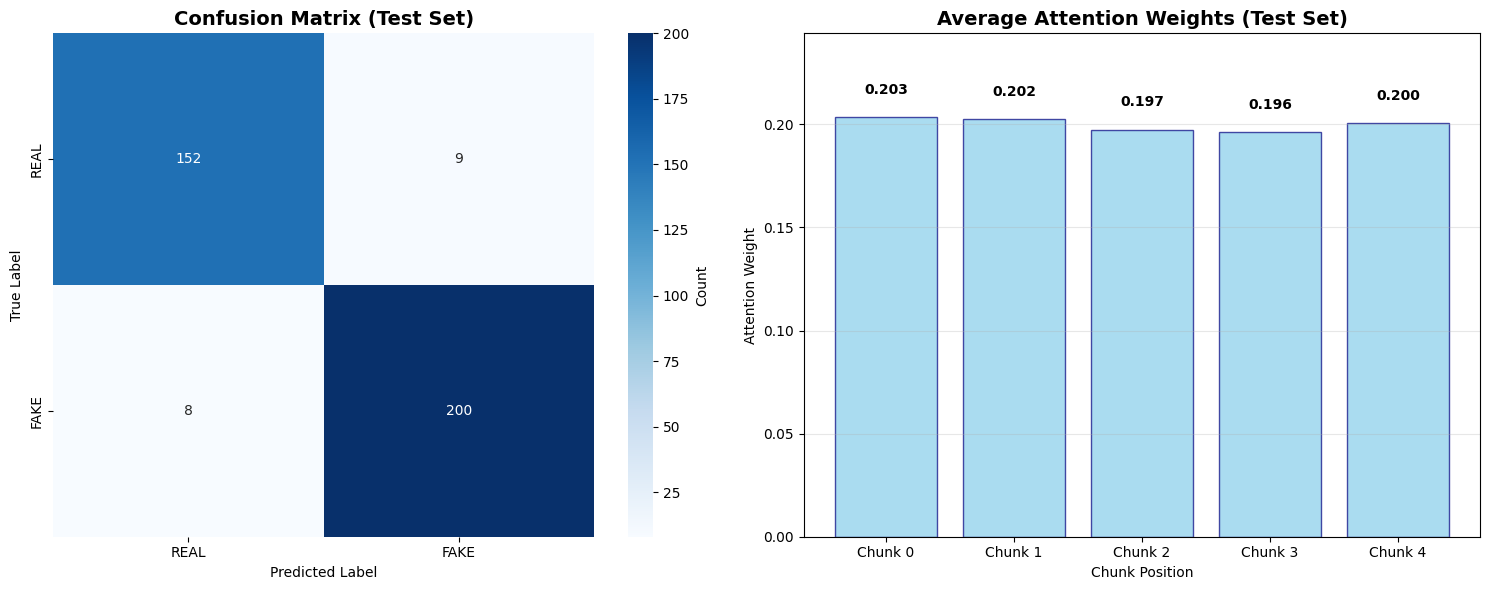

✓ Test results visualized and saved


In [ ]:
# ================================================================================
# CELL 17: VISUALIZE TEST RESULTS (NEW)
# ================================================================================

import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Confusion Matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['REAL', 'FAKE'],
    yticklabels=['REAL', 'FAKE'],
    ax=axes[0],
    cbar_kws={'label': 'Count'}
)
axes[0].set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Plot 2: Attention Distribution
chunk_labels = [f'Chunk {i}' for i in range(5)]
axes[1].bar(chunk_labels, mean_attention, color='skyblue', edgecolor='navy', alpha=0.7)
axes[1].set_title('Average Attention Weights (Test Set)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Attention Weight')
axes[1].set_xlabel('Chunk Position')
axes[1].set_ylim([0, mean_attention.max() * 1.2])
axes[1].grid(axis='y', alpha=0.3)

# Add values on bars
for i, v in enumerate(mean_attention):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('test_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Test results visualized and saved")


In [ ]:
# ================================================================================
# CELL 18: EXPORT MODEL TO ONNX (NEW)
# ================================================================================

print("=" * 80)
print("EXPORTING MODEL TO ONNX FORMAT")
print("=" * 80)

# Install ONNX packages if not available
try:
    import onnx
    import onnxruntime as ort
except ImportError:
    print("Installing ONNX dependencies...")
    !pip install -q onnx onnxruntime
    import onnx
    import onnxruntime as ort

# ========================================
# 1. LOAD BEST MODEL
# ========================================
drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
best_model_path = os.path.join(drive_save_dir, 'han_rag_best.pth')

checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")

# ========================================
# 2. CREATE DUMMY INPUT
# ========================================
# ONNX cần dummy input để trace model
batch_size = 1
num_chunks = 5
max_length = 256

dummy_chunk_input_ids = torch.randint(
    0, tokenizer.vocab_size,
    (batch_size, num_chunks, max_length),
    dtype=torch.long
).to(device)

dummy_chunk_attention_masks = torch.ones(
    (batch_size, num_chunks, max_length),
    dtype=torch.long
).to(device)

print(f"\n✓ Created dummy inputs:")
print(f"  chunk_input_ids shape: {dummy_chunk_input_ids.shape}")
print(f"  chunk_attention_masks shape: {dummy_chunk_attention_masks.shape}")

# Test forward pass
with torch.no_grad():
    test_output = model(dummy_chunk_input_ids, dummy_chunk_attention_masks)
    print(f"\n✓ Test forward pass successful:")
    print(f"  logits shape: {test_output['logits'].shape}")
    print(f"  chunk_attention shape: {test_output['chunk_attention'].shape}")

# ========================================
# 3. EXPORT TO ONNX
# ========================================
onnx_path = os.path.join(drive_save_dir, 'han_rag_model.onnx')

print(f"\n{'='*80}")
print("EXPORTING TO ONNX...")
print(f"{'='*80}")

# Input names
input_names = ['chunk_input_ids', 'chunk_attention_masks']
output_names = ['logits', 'chunk_attention']

# Dynamic axes (để support batch size linh hoạt)
dynamic_axes = {
    'chunk_input_ids': {0: 'batch_size'},
    'chunk_attention_masks': {0: 'batch_size'},
    'logits': {0: 'batch_size'},
    'chunk_attention': {0: 'batch_size'}
}

# Export
torch.onnx.export(
    model,
    (dummy_chunk_input_ids, dummy_chunk_attention_masks),
    onnx_path,
    export_params=True,
    opset_version=14,  # ONNX opset version
    do_constant_folding=True,
    input_names=input_names,
    output_names=output_names,
    dynamic_axes=dynamic_axes,
    verbose=False
)

print(f"✅ Model exported to: {onnx_path}")

# Check file size
onnx_size_mb = os.path.getsize(onnx_path) / (1024 * 1024)
print(f"   File size: {onnx_size_mb:.2f} MB")

# ========================================
# 4. VALIDATE ONNX MODEL
# ========================================
print(f"\n{'='*80}")
print("VALIDATING ONNX MODEL")
print(f"{'='*80}")

# Load and check ONNX model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model is valid")

# Print model info
print(f"\nONNX Model Info:")
print(f"  IR Version: {onnx_model.ir_version}")
print(f"  Producer: {onnx_model.producer_name}")
print(f"  Opset Version: {onnx_model.opset_import[0].version}")

print(f"\nInputs:")
for input_tensor in onnx_model.graph.input:
    print(f"  - {input_tensor.name}: {[d.dim_value if d.dim_value > 0 else 'dynamic' for d in input_tensor.type.tensor_type.shape.dim]}")

print(f"\nOutputs:")
for output_tensor in onnx_model.graph.output:
    print(f"  - {output_tensor.name}: {[d.dim_value if d.dim_value > 0 else 'dynamic' for d in output_tensor.type.tensor_type.shape.dim]}")

# ========================================
# 5. TEST ONNX INFERENCE
# ========================================
print(f"\n{'='*80}")
print("TESTING ONNX INFERENCE")
print(f"{'='*80}")

# Create ONNX Runtime session
ort_session = ort.InferenceSession(
    onnx_path,
    providers=['CPUExecutionProvider']  # Use CPU for compatibility
)

print(f"✓ ONNX Runtime session created")
print(f"  Providers: {ort_session.get_providers()}")

# Prepare test input (use a real sample from test set)
test_sample = test_dataset[0]
test_input_ids = test_sample['chunk_input_ids'].unsqueeze(0).numpy()
test_attention_masks = test_sample['chunk_attention_masks'].unsqueeze(0).numpy()

# Run ONNX inference
onnx_inputs = {
    'chunk_input_ids': test_input_ids,
    'chunk_attention_masks': test_attention_masks
}

onnx_outputs = ort_session.run(None, onnx_inputs)
onnx_logits = onnx_outputs[0]
onnx_attention = onnx_outputs[1]

print(f"\n✓ ONNX inference successful:")
print(f"  Logits shape: {onnx_logits.shape}")
print(f"  Attention shape: {onnx_attention.shape}")

# Compare with PyTorch output
model.eval()
with torch.no_grad():
    pytorch_outputs = model(
        test_sample['chunk_input_ids'].unsqueeze(0).to(device),
        test_sample['chunk_attention_masks'].unsqueeze(0).to(device)
    )
    pytorch_logits = pytorch_outputs['logits'].cpu().numpy()
    pytorch_attention = pytorch_outputs['chunk_attention'].cpu().numpy()

# Calculate difference
logits_diff = np.abs(onnx_logits - pytorch_logits).max()
attention_diff = np.abs(onnx_attention - pytorch_attention).max()

print(f"\n{'='*80}")
print("PYTORCH vs ONNX COMPARISON")
print(f"{'='*80}")
print(f"Max logits difference: {logits_diff:.6f}")
print(f"Max attention difference: {attention_diff:.6f}")

if logits_diff < 1e-4 and attention_diff < 1e-4:
    print("✅ EXCELLENT: Outputs match within tolerance (< 1e-4)")
elif logits_diff < 1e-3 and attention_diff < 1e-3:
    print("✅ GOOD: Outputs match within acceptable tolerance (< 1e-3)")
else:
    print("⚠️ WARNING: Significant difference detected!")

# Show predictions
pytorch_pred = np.argmax(pytorch_logits, axis=1)[0]
onnx_pred = np.argmax(onnx_logits, axis=1)[0]

print(f"\nPredictions:")
print(f"  PyTorch: {pytorch_pred} ({'FAKE' if pytorch_pred == 1 else 'REAL'})")
print(f"  ONNX:    {onnx_pred} ({'FAKE' if onnx_pred == 1 else 'REAL'})")
print(f"  Match: {'✅ YES' if pytorch_pred == onnx_pred else '❌ NO'}")

# ========================================
# 6. BENCHMARK INFERENCE SPEED
# ========================================
print(f"\n{'='*80}")
print("BENCHMARKING INFERENCE SPEED")
print(f"{'='*80}")

import time

num_runs = 100

# PyTorch benchmark
model.to('cpu')  # Fair comparison on CPU
pytorch_times = []
for _ in range(num_runs):
    start = time.time()
    with torch.no_grad():
        _ = model(
            test_sample['chunk_input_ids'].unsqueeze(0),
            test_sample['chunk_attention_masks'].unsqueeze(0)
        )
    pytorch_times.append(time.time() - start)

pytorch_avg = np.mean(pytorch_times) * 1000  # Convert to ms

# ONNX benchmark
onnx_times = []
for _ in range(num_runs):
    start = time.time()
    _ = ort_session.run(None, onnx_inputs)
    onnx_times.append(time.time() - start)

onnx_avg = np.mean(onnx_times) * 1000  # Convert to ms

print(f"\nInference time (average over {num_runs} runs):")
print(f"  PyTorch: {pytorch_avg:.2f} ms")
print(f"  ONNX:    {onnx_avg:.2f} ms")
print(f"  Speedup: {pytorch_avg/onnx_avg:.2f}x")

if onnx_avg < pytorch_avg:
    print(f"✅ ONNX is {(pytorch_avg/onnx_avg - 1)*100:.1f}% faster!")
else:
    print(f"⚠️ PyTorch is {(onnx_avg/pytorch_avg - 1)*100:.1f}% faster")

# ========================================
# 7. SAVE METADATA
# ========================================
onnx_metadata = {
    'model_type': 'HierarchicalAttentionClassifier',
    'framework': 'PyTorch -> ONNX',
    'opset_version': 14,
    'input_shapes': {
        'chunk_input_ids': [batch_size, num_chunks, max_length],
        'chunk_attention_masks': [batch_size, num_chunks, max_length]
    },
    'output_shapes': {
        'logits': [batch_size, 2],
        'chunk_attention': [batch_size, num_chunks]
    },
    'model_config': {
        'phobert_name': 'vinai/phobert-base-v2',
        'chunk_attention_hidden': 128,
        'num_classes': 2,
        'dropout': 0.3,
        'chunk_size': 400,
        'top_k': 5,
        'max_length': 256
    },
    'training_info': {
        'best_epoch': checkpoint['epoch'],
        'val_f1': float(checkpoint['val_f1']),
        'val_acc': float(checkpoint.get('val_acc', 0))
    },
    'validation': {
        'max_logits_diff': float(logits_diff),
        'max_attention_diff': float(attention_diff),
        'predictions_match': bool(pytorch_pred == onnx_pred)
    },
    'performance': {
        'pytorch_inference_ms': float(pytorch_avg),
        'onnx_inference_ms': float(onnx_avg),
        'speedup': float(pytorch_avg/onnx_avg)
    }
}

metadata_path = os.path.join(drive_save_dir, 'onnx_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(onnx_metadata, f, indent=2, ensure_ascii=False)

print(f"\n✓ Metadata saved to: {metadata_path}")

# ========================================
# 8. SUMMARY
# ========================================
print(f"\n{'='*80}")
print("ONNX EXPORT SUMMARY")
print(f"{'='*80}")
print(f"\n📁 Exported files in: {drive_save_dir}")
print(f"   ├── han_rag_model.onnx ({onnx_size_mb:.2f} MB)")
print(f"   └── onnx_metadata.json")
print(f"\n✅ Model successfully exported and validated!")
print(f"   - Outputs match PyTorch (diff < {max(logits_diff, attention_diff):.6f})")
print(f"   - ONNX inference: {onnx_avg:.2f} ms")
print(f"   - Ready for deployment!")


EXPORTING MODEL TO ONNX FORMAT


/tmp/ipython-input-986392926.py:82: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1217 08:35:54.759000 368 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 14 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


✓ Loaded best model from epoch 5

✓ Created dummy inputs:
  chunk_input_ids shape: torch.Size([1, 5, 256])
  chunk_attention_masks shape: torch.Size([1, 5, 256])

✓ Test forward pass successful:
  logits shape: torch.Size([1, 2])
  chunk_attention shape: torch.Size([1, 5])

EXPORTING TO ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/no_previous_version.h:26: adapt: Assertion `

Applied 5 of general pattern rewrite rules.
✅ Model exported to: /content/drive/MyDrive/FakeNewsModels/model_v2/han_rag_model.onnx
   File size: 1.42 MB

VALIDATING ONNX MODEL
✓ ONNX model is valid

ONNX Model Info:
  IR Version: 10
  Producer: pytorch
  Opset Version: 18

Inputs:
  - chunk_input_ids: ['dynamic', 5, 256]
  - chunk_attention_masks: ['dynamic', 5, 256]

Outputs:
  - logits: ['dynamic', 2]
  - chunk_attention: ['dynamic', 5]

TESTING ONNX INFERENCE
✓ ONNX Runtime session created
  Providers: ['CPUExecutionProvider']

✓ ONNX inference successful:
  Logits shape: (1, 2)
  Attention shape: (1, 5)

PYTORCH vs ONNX COMPARISON
Max logits difference: 0.000000
Max attention difference: 0.000000
✅ EXCELLENT: Outputs match within tolerance (< 1e-4)

Predictions:
  PyTorch: 0 (REAL)
  ONNX:    0 (REAL)
  Match: ✅ YES

BENCHMARKING INFERENCE SPEED

Inference time (average over 100 runs):
  PyTorch: 3430.51 ms
  ONNX:    3586.39 ms
  Speedup: 0.96x
⚠️ PyTorch is 4.5% faster

✓ Metadat

In [ ]:
# ================================================================================
# CELL 19: TEST ONNX MODEL WITH TEXT INPUT (NEW)
# ================================================================================

def predict_with_onnx(
    title: str,
    content: str,
    ort_session: ort.InferenceSession,
    tokenizer,
    normalizer,
    retriever,
    device='cpu'
) -> Dict:
    """
    Predict using ONNX model with raw text input
    """
    # Create mini dataset
    test_df = pd.DataFrame({
        'title': [title],
        'content': [content],
        'label': [0]  # Dummy
    })

    test_dataset = HierarchicalAttentionDataset(
        df=test_df,
        tokenizer=tokenizer,
        normalizer=normalizer,
        retriever=retriever,
        chunk_size=400,
        top_k=5,
        max_length=256,
        min_chunks=3
    )

    sample = test_dataset[0]

    # Prepare ONNX inputs
    onnx_inputs = {
        'chunk_input_ids': sample['chunk_input_ids'].unsqueeze(0).numpy(),
        'chunk_attention_masks': sample['chunk_attention_masks'].unsqueeze(0).numpy()
    }

    # Run inference
    onnx_outputs = ort_session.run(None, onnx_inputs)
    logits = onnx_outputs[0][0]  # [2]
    chunk_attention = onnx_outputs[1][0]  # [5]

    # Calculate probabilities
    probs = np.exp(logits) / np.sum(np.exp(logits))
    pred_class = np.argmax(probs)

    return {
        'prediction': 'FAKE' if pred_class == 1 else 'REAL',
        'confidence': float(probs[pred_class]),
        'probabilities': {
            'REAL': float(probs[0]),
            'FAKE': float(probs[1])
        },
        'chunk_attention': chunk_attention.tolist()
    }


# Test với COVID-19 example
print("=" * 80)
print("TESTING ONNX MODEL WITH TEXT INPUT")
print("=" * 80)

test_title = "NÓNG: Thế giới đối mặt với COVID-19"
test_content = """NÓNG ! 15/3 sẽ là ngày đáng nhớ cho không chỉ Việt Nam mà của toàn thế giới do những gì COVID-19 gây ra !!! - Rạng sáng 15/3, Pháp ra lệnh đóng cửa toàn bộ nhà hàng, rạp chiếu phim, cửa hàng,..trừ.. siêu thị, trạm xăng, ngân hàng, tabac, presse báo chí và pharmacie."""

print(f"\nInput:")
print(f"  Title: {test_title}")
print(f"  Content: {test_content[:150]}...")

# Predict
result = predict_with_onnx(
    test_title,
    test_content,
    ort_session,
    tokenizer,
    normalizer,
    retriever
)

print(f"\n{'='*80}")
print("ONNX PREDICTION RESULT")
print(f"{'='*80}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"\nProbabilities:")
print(f"  REAL: {result['probabilities']['REAL']:.4f}")
print(f"  FAKE: {result['probabilities']['FAKE']:.4f}")

print(f"\nChunk Attention Weights:")
for i, weight in enumerate(result['chunk_attention']):
    bar_length = int(weight * 40 / max(result['chunk_attention']))
    bar = "█" * bar_length
    print(f"  Chunk {i}: {bar} {weight:.4f}")

print("\n✅ ONNX model inference completed successfully!")


TESTING ONNX MODEL WITH TEXT INPUT

Input:
  Title: NÓNG: Thế giới đối mặt với COVID-19
  Content: NÓNG ! 15/3 sẽ là ngày đáng nhớ cho không chỉ Việt Nam mà của toàn thế giới do những gì COVID-19 gây ra !!! - Rạng sáng 15/3, Pháp ra lệnh đóng cửa to...

ONNX PREDICTION RESULT
Prediction: REAL
Confidence: 0.9914

Probabilities:
  REAL: 0.9914
  FAKE: 0.0086

Chunk Attention Weights:
  Chunk 0: ████████████████████████████████████████ 0.2000
  Chunk 1: ████████████████████████████████████████ 0.2000
  Chunk 2: ████████████████████████████████████████ 0.2000
  Chunk 3: ████████████████████████████████████████ 0.2000
  Chunk 4: ████████████████████████████████████████ 0.2000

✅ ONNX model inference completed successfully!


In [ ]:
# ================================================================================
# CELL 21: SAVE DEPLOYMENT PACKAGE (THÊM SAU CELL 18)
# ================================================================================

import shutil
import os

print("=" * 80)
print("CREATING DEPLOYMENT PACKAGE")
print("=" * 80)

drive_save_dir = '/content/drive/MyDrive/FakeNewsModels/model_v2'
deployment_dir = os.path.join(drive_save_dir, 'deployment_package')
os.makedirs(deployment_dir, exist_ok=True)

# ========================================
# 1. SAVE TOKENIZER
# ========================================
print("\n1. Saving tokenizer...")
tokenizer_dir = os.path.join(deployment_dir, 'tokenizer')
tokenizer.save_pretrained(tokenizer_dir)
print(f"✓ Tokenizer saved: {os.listdir(tokenizer_dir)}")

# ========================================
# 2. SAVE RETRIEVER
# ========================================
print("\n2. Saving retriever...")
retriever_dir = os.path.join(deployment_dir, 'retriever')
retriever.save(retriever_dir)
print(f"✓ Retriever saved")

# ========================================
# 3. COPY ONNX
# ========================================
print("\n3. Copying ONNX model...")
shutil.copy(
    os.path.join(drive_save_dir, 'han_rag_model.onnx'),
    os.path.join(deployment_dir, 'han_rag_model.onnx')
)

# ========================================
# 4. SAVE CONFIG
# ========================================
print("\n4. Saving config...")
config = {
    'model_version': 'v2',
    'best_epoch': checkpoint['epoch'],
    'val_f1': float(checkpoint['val_f1']),
    'model_config': {
        'chunk_size': 400,
        'top_k': 5,
        'max_length': 256
    }
}

with open(os.path.join(deployment_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

# ========================================
# 5. CREATE ZIP
# ========================================
print("\n5. Creating ZIP archive...")
shutil.make_archive(
    os.path.join(drive_save_dir, 'deployment_package'),
    'zip',
    deployment_dir
)

zip_path = os.path.join(drive_save_dir, 'deployment_package.zip')
zip_size = os.path.getsize(zip_path) / (1024 * 1024)

print("\n" + "=" * 80)
print("✅ DEPLOYMENT PACKAGE READY")
print("=" * 80)
print(f"\n📦 ZIP: {zip_path} ({zip_size:.2f} MB)")
print(f"\nContents:")
print(f"  ├── han_rag_model.onnx")
print(f"  ├── tokenizer/ (PhoBERT)")
print(f"  ├── retriever/ (Vietnamese SBERT)")
print(f"  └── config.json")


CREATING DEPLOYMENT PACKAGE

1. Saving tokenizer...
✓ Tokenizer saved: ['tokenizer_config.json', 'special_tokens_map.json', 'added_tokens.json', 'vocab.txt', 'bpe.codes']

2. Saving retriever...
✓ Retriever saved

3. Copying ONNX model...

4. Saving config...

5. Creating ZIP archive...

✅ DEPLOYMENT PACKAGE READY

📦 ZIP: /content/drive/MyDrive/FakeNewsModels/model_v2/deployment_package.zip (441.28 MB)

Contents:
  ├── han_rag_model.onnx
  ├── tokenizer/ (PhoBERT)
  ├── retriever/ (Vietnamese SBERT)
  └── config.json
